In [1]:
!pip install tensorflow -q

In [2]:
!pip install spacy -q


In [10]:
!python -m spacy download en_core_web_sm -q

2022-10-26 18:05:46.077905: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 12.8 MB 8.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Import libraries

In [28]:
import pandas as pd
import numpy as np
import io
import os
import re
import shutil
import string
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM

import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS

DATA ANALYSIS

Import dataset

In [4]:
data_train = pd.read_csv("/train.csv")
data_test = pd.read_csv("/test.csv")
data_sample = pd.read_csv("/sample_submission.csv")

In [5]:
data_train["target"].value_counts()


0    4342
1    3271
Name: target, dtype: int64

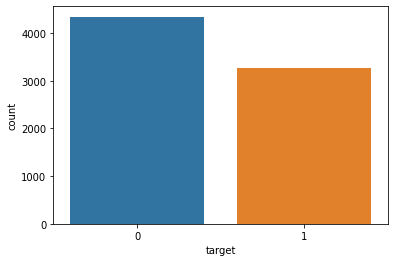

In [7]:
sns.countplot(x=data_train['target'])


In [8]:
print("Missing values train set:")
print(data_train.isna().sum()*100 / data_train.shape[0])

Missing values train set:
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


In [9]:
data_train = data_train.fillna('')
data_train.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


WORD EMBEDDING : PREPROCESSING

In [12]:
nlp = en_core_web_sm.load()

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


Ma fonction

In [13]:

#Define function to clean text :

pattern = r'[0-9]'
prefixes = "http"
def clean_text(text):
  text = "".join([ch for ch in text if ch.isalnum() or ch == " "]) # Remove non-alphanuleric characters
  text = re.sub(" +", " ", text).lower().strip() # Decrease number of characters
  text = " ".join([token.lemma_ for token in nlp(text) if token.text not in STOP_WORDS and token.lemma_ not in STOP_WORDS]) # Lemmatize words ans delete stop words
  text = re.sub(pattern, ' ', text) # Delete digits and replace it with blank space
  text = ' '.join( [w for w in text.split() if len(w)>1] ) # Delete words with one character

  return text

In [14]:
data_train["text_clean"] = data_train["text"].apply(lambda x: clean_text(x))
data_train["keyword_clean"] = data_train["keyword"].astype(str).apply(lambda x: clean_text(x)+" ")

In [15]:
data_train["all_text_clean"] = +data_train["keyword_clean"] + data_train["text_clean"]

Encoding text

In [16]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000) # instanciate the tokenizer
tokenizer.fit_on_texts(data_train.all_text_clean)
data_train["all_text_encoded"] = tokenizer.texts_to_sequences(data_train.all_text_clean)

data_train["len"] = data_train["all_text_encoded"].apply(lambda x: len(x))
data_train = data_train[data_train["len"]!=0]

In [18]:
data_train.head()


,id,keyword,location,text,target,text_clean,keyword_clean,all_text_clean,all_text_encoded,len
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,,deed reason earthquake allah forgive,"[438, 100, 1384, 1961]",4
1,4,,,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,,forest fire near la ronge sask canada,"[73, 2, 259, 485, 1036]",5
2,5,,,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,,resident ask shelter place notify officer eva...,"[1385, 467, 1712, 376, 360, 104, 1712, 376, 35...",10
3,6,,,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...,,people receive wildfire evacuation order cali...,"[19, 75, 104, 353, 71]",5
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,,got send photo ruby alaska smoke wildfire pou...,"[333, 283, 212, 1713, 105, 75, 186]",7


Padding vectors

In [19]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(data_train.all_text_encoded, padding="post")

In [20]:
full_ds = tf.data.Dataset.from_tensor_slices((text_pad, data_train.target))

Split train / test

In [22]:
# Train Test Split
TAKE_SIZE = int(0.7*data_train.shape[0])

train_data70 = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data70 = train_data70.batch(64)

test_data30 = full_ds.skip(TAKE_SIZE)
test_data30 = test_data30.batch(64)

In [23]:
# Print one batch 
for tweet, target in train_data.take(1):
  print(tweet, target)

tf.Tensor(
[[  92  368  905 ...    0    0    0]
 [  90   90  383 ...    0    0    0]
 [  13  954  385 ...    0    0    0]
 ...
 [  34  366  262 ...    0    0    0]
 [ 232 1765  157 ...    0    0    0]
 [ 136  197  234 ...    0    0    0]], shape=(64, 18), dtype=int32) tf.Tensor(
[0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0], shape=(64,), dtype=int64)


Model 1 : With word embbeding

In [24]:
vocab_size = 2000
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 16, input_shape=[tweet.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie ÃƒÂ©gale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 16)            32016     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 32,433
Trainable params: 32,433
Non-trainable params: 0
____________________________________________________

In [26]:
optimizer= tf.keras.optimizers.Adam(0.0002)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [27]:
# Train model
history = model.fit(train_data70, 
                    epochs=20, 
                    validation_data=test_data30)

Epoch 1/20
84/84 [==============================] - 2s 5ms/step - loss: 0.6930 - accuracy: 0.5274 - val_loss: 0.6923 - val_accuracy: 0.5580
Epoch 2/20
84/84 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5753 - val_loss: 0.6900 - val_accuracy: 0.5580
Epoch 3/20
84/84 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.5884 - val_loss: 0.6864 - val_accuracy: 0.5650
Epoch 4/20
84/84 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.6553 - val_loss: 0.6790 - val_accuracy: 0.6562
Epoch 5/20
84/84 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.7587 - val_loss: 0.6652 - val_accuracy: 0.7438
Epoch 6/20
84/84 [==============================] - 0s 4ms/step - loss: 0.6410 - accuracy: 0.8029 - val_loss: 0.6460 - val_accuracy: 0.7556
Epoch 7/20
84/84 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.8141 - val_loss: 0.6248 - val_accuracy: 0.7591
Epoch 8/20
84/84 [==

Eval Model

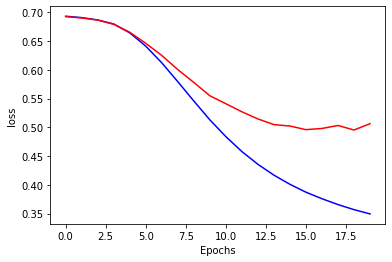

In [29]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

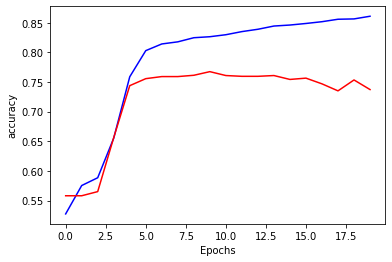

In [30]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

Model 2 : with RNN


In [31]:
vocab_size = 2000
embedding_dim=16 # the dimensionality of the representation space

model_rnn = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[tweet.shape[1],], name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  SimpleRNN(units=64, return_sequences=True, kernel_regularizer = "l1"), # maintains the sequential nature
  SimpleRNN(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

In [32]:
model_rnn.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 16)            32016     
                                                                 
 simple_rnn (SimpleRNN)      (None, 18, 64)            5184      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 40,849
Trainable params: 40,849
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [35]:
history_rnn = model_rnn.fit(
    train_data70,
    validation_data=test_data30,
    epochs=10)


Epoch 1/10
84/84 [==============================] - 1s 16ms/step - loss: 1.7963 - accuracy: 0.7347 - val_loss: 1.8306 - val_accuracy: 0.6531
Epoch 2/10
84/84 [==============================] - 1s 15ms/step - loss: 1.6658 - accuracy: 0.7766 - val_loss: 1.7424 - val_accuracy: 0.6750
Epoch 3/10
84/84 [==============================] - 1s 15ms/step - loss: 1.5552 - accuracy: 0.8077 - val_loss: 1.6772 - val_accuracy: 0.6873
Epoch 4/10
84/84 [==============================] - 1s 15ms/step - loss: 1.4565 - accuracy: 0.8269 - val_loss: 1.6257 - val_accuracy: 0.6899
Epoch 5/10
84/84 [==============================] - 1s 16ms/step - loss: 1.3718 - accuracy: 0.8474 - val_loss: 1.6288 - val_accuracy: 0.6719
Epoch 6/10
84/84 [==============================] - 1s 16ms/step - loss: 1.2989 - accuracy: 0.8596 - val_loss: 1.6169 - val_accuracy: 0.6614
Epoch 7/10
84/84 [==============================] - 1s 14ms/step - loss: 1.2338 - accuracy: 0.8695 - val_loss: 1.6330 - val_accuracy: 0.6518
Epoch 8/10
84

Eval model 2

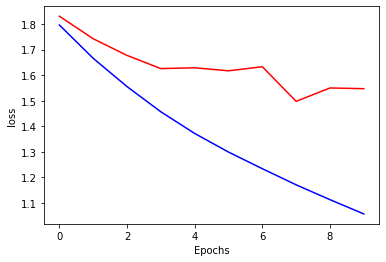

In [36]:
# Visualization of the training process on the loss function 
plt.plot(history_rnn.history["loss"], color="b")
plt.plot(history_rnn.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

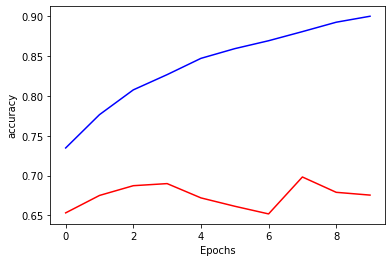

In [37]:
# Visualization of accuracy training 
plt.plot(history_rnn.history["accuracy"], color="b")
plt.plot(history_rnn.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()


Model 3 : with LSTM

In [38]:
vocab_size = 2000
embedding_dim=16 # the dimensionality of the representation space

model_lstm = Sequential([
  Embedding(vocab_size+1, embedding_dim, input_shape=[tweet.shape[1],], name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)), # maintains the sequential nature
  LSTM(units=32, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])

In [39]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(0.00002),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [40]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 16)            32016     
                                                                 
 bidirectional (Bidirectiona  (None, 18, 128)          41472     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 94,641
Trainable params: 94,641
Non-trainable params: 0
__________________________________________________

In [41]:
history_lstm = model_lstm.fit(
    train_data70,
    validation_data=test_data30,
    epochs=20)

Epoch 1/20
84/84 [==============================] - 12s 74ms/step - loss: 0.6911 - accuracy: 0.5753 - val_loss: 0.6899 - val_accuracy: 0.5580
Epoch 2/20
84/84 [==============================] - 4s 46ms/step - loss: 0.6873 - accuracy: 0.5753 - val_loss: 0.6870 - val_accuracy: 0.5580
Epoch 3/20
84/84 [==============================] - 4s 42ms/step - loss: 0.6834 - accuracy: 0.5753 - val_loss: 0.6837 - val_accuracy: 0.5580
Epoch 4/20
84/84 [==============================] - 3s 41ms/step - loss: 0.6790 - accuracy: 0.5753 - val_loss: 0.6814 - val_accuracy: 0.5580
Epoch 5/20
84/84 [==============================] - 4s 46ms/step - loss: 0.6756 - accuracy: 0.5753 - val_loss: 0.6797 - val_accuracy: 0.5580
Epoch 6/20
84/84 [==============================] - 4s 42ms/step - loss: 0.6722 - accuracy: 0.5753 - val_loss: 0.6770 - val_accuracy: 0.5580
Epoch 7/20
84/84 [==============================] - 4s 47ms/step - loss: 0.6668 - accuracy: 0.5753 - val_loss: 0.6721 - val_accuracy: 0.5580
Epoch 8/20
8

Eval model 3

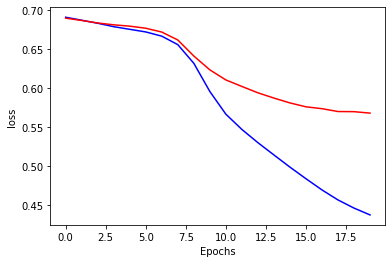

In [42]:
# Visualization of the training process on the loss function 
plt.plot(history_lstm.history["loss"], color="b")
plt.plot(history_lstm.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

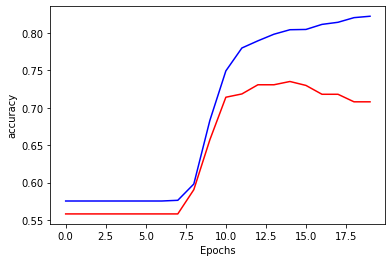

In [43]:
# Visualization of accuracy training 
plt.plot(history_lstm.history["accuracy"], color="b")
plt.plot(history_lstm.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

To conclude

Conclusion

Model 1 :
- Simpliest and it has 
- Relatively good performance after the preprocessings were tuned. 
- Loss and val loss decrease
- No overfit
- Accuracy : 0,75.
--> Performance was improved with setting low learning rate



Model 2 : 
- Simple RNN. 
- Not really good performance
- Overfitting quickly with default parameters.
-->Limit overfitting with setting Ridge regularizer one the first RNN layer, and low learning rate.

Model 3 :
- More complex with LSTM 
- Slow learner
- Not performing well at first and 
- Overfit with default parameters
--> Set the learning rate very low (0, 00002), and rise the number of epochs : it does not learn anything before epoch n°10. Then after it has quick learning and reaches some good performance that could compare with model 1.
- Complex and slow, Model 1 should be prefered.


Prediction

In [50]:
predictions = model_lstm.predict(test_data30)

36/36 [==============================] - 2s 15ms/step


In [51]:
predictions.reshape(1, -1)


array([[0.6591819 , 0.09239586, 0.17977451, ..., 0.69539845, 0.67797136,
        0.7973815 ]], dtype=float32)

In [52]:
predictions = pd.DataFrame(predictions, columns=["Predictions"])


In [53]:
predictions["Predictions"] = predictions["Predictions"].apply(lambda x: 0 if x<0.5 else 1)


In [54]:
predictions

,Predictions
0,1
1,0
2,0
3,1
4,1
...,...
2278,1
2279,1
2280,1
2281,1
